In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

In [3]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)

### `LinearRegression` Classifier

In [5]:
lin_reg_pipeline = Pipeline(
    [("feature_scaling", StandardScaler()), ("lin_reg", LinearRegression())]
)
lin_reg_cv_results = cross_validate(
    lin_reg_pipeline,
    train_features,
    train_labels,
    cv=shuffle_split_cv,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
)

lin_reg_errors = pd.Series(-lin_reg_cv_results['test_score'], name='Linear Regression Error')

### `DummyRegressor`

In [6]:
def dummy_regressor_baseline(strategy, constant_val=None, quantile_val=None):
    baseline_model_median = DummyRegressor(
        strategy=strategy, constant=constant_val, quantile=quantile_val
    )
    baseline_median_cv_results = cross_validate(
        baseline_model_median,
        train_features,
        train_labels,
        cv=shuffle_split_cv,
        scoring="neg_mean_absolute_error",
        n_jobs=2,
    )
    return pd.Series(
        -baseline_median_cv_results["test_score"], name="Dummy regressor error"
    )

In [7]:
baseline_median_cv_results_errors = dummy_regressor_baseline(strategy='median')
baseline_mean_cv_results_errors = dummy_regressor_baseline(strategy='mean')
baseline_constant_cv_results_errors = dummy_regressor_baseline(
strategy='constant', constant_val=2)
baseline_quantile_cv_results_errors = dummy_regressor_baseline(
strategy='quantile', quantile_val=0.55)

In [8]:
dummy_error_df = pd.concat(
    [
        baseline_median_cv_results_errors,
        baseline_mean_cv_results_errors,
        baseline_constant_cv_results_errors,
        baseline_quantile_cv_results_errors,
    ],
    axis=1,
)
dummy_error_df.columns = ["Median CV", "Mean CV", "Constant CV", "Quantile CV"]

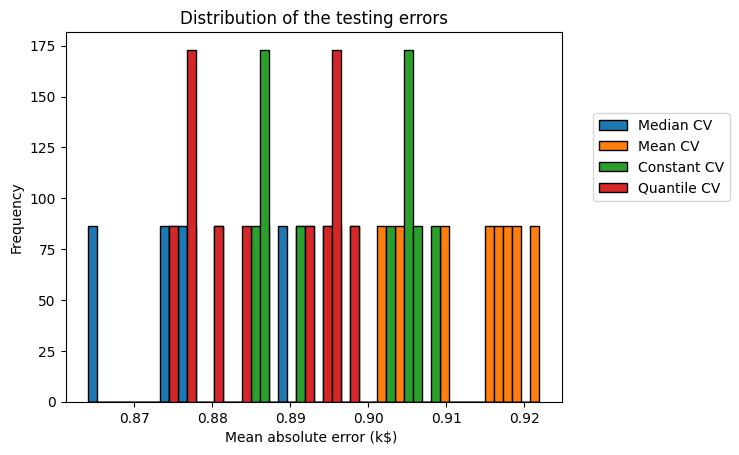

In [9]:
dummy_error_df.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel ("Mean absolute error (k$) ")
_= plt.title("Distribution of the testing errors")

### `permutation_test_score`
- It permutes the target to generate randomized data and computes the empirical p-value against the null hypothesis, that
features and targets are independent.

In [11]:
score, permutation_score, pvalue = permutation_test_score(
    lin_reg_pipeline,
    train_features,
    train_labels,
    cv=shuffle_split_cv,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
    n_permutations=30,
)
permutation_errors = pd.Series(-permutation_score, name="Permuted error")

permutation_errors

0     0.914465
1     0.916087
2     0.915011
3     0.911122
4     0.913261
5     0.914287
6     0.916943
7     0.906607
8     0.908736
9     0.915461
10    0.908469
11    0.911740
12    0.918571
13    0.914671
14    0.903967
15    0.912393
16    0.910955
17    0.917296
18    0.905294
19    0.914366
20    0.919930
21    0.916619
22    0.911047
23    0.915632
24    0.910143
25    0.915261
26    0.906802
27    0.907964
28    0.910330
29    0.915456
Name: Permuted error, dtype: float64

### Model Comparison

In [12]:
error_df = pd.concat(
    [lin_reg_errors, baseline_median_cv_results_errors, permutation_errors], axis=1
)

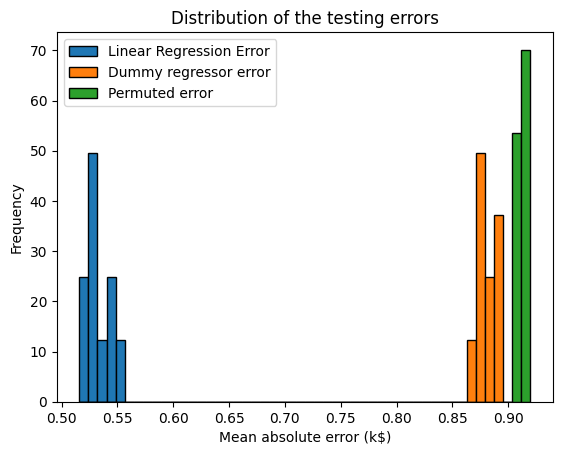

In [13]:
error_df.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(loc="best")
plt.xlabel("Mean absolute error (k$)")
_= plt. title("Distribution of the testing errors")